# Visualizing Stratified K-Folds

In [1]:
K = 5
DYNAMIC_SPLIT = 1/K # <== Expected validation ratio. Training ratio will be 1-(1/K). Just for when needed to view.
RANDOM_SEED = 1 # <==  <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

In [2]:
#Python Libraries
import time
from datetime import datetime
import os
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#Metrics (for in-tuning testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
import lightgbm
# import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

start = end = 0
LOG_FILENAME = "LGBM_Tuning_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{OUTPUT_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)
def print_to_file(label, output):
    global OUTPUT_FILENAME
    filename = OUTPUT_FILENAME + "_" + label + ".tune"
    with open("Outputs/" + filename, 'w') as f:
        f.write(str(output))
        f.close()

In [3]:
def get_strat_kfold():
    global K
    return StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

#K-folds sample visualization
def kfolds_vis(dataset):
    global K
    X = dataset.iloc[:,1:] #All rows, 2nd to last column
    y = dataset.iloc[:,0] #All rows, first column only
    fig, ax = plt.subplots(figsize=(10,K+1), dpi=300)
    train = plot_cv_indices(get_strat_kfold(), X, y, ax, K)
    plt.show()

#K-folds sample visualization (inner workings)
def plot_cv_indices(cv, X, y, ax, n_splits, lw=25):
    #From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt], indices[tr] = 1,0
        ax.scatter(range(len(indices)), [ii] * len(indices), c=indices, marker="_", 
                   lw=lw, cmap=plt.cm.Paired, vmin=0, vmax=1)
    #ax.scatter(range(len(X)), [ii] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired)
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels, xlabel="Dataset Subsample", ylabel="CV iteration", ylim=[n_splits,-1], xlim=[0, X.shape[0]])
    ax.set_title("{}".format(type(cv).__name__))
    return ax

In [4]:
#Setting filenames of files
TB_Train_LGBM = "../Dataset/TB/TB_LGBM.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test_LGBM = "../Dataset/TB/TB_Test_LGBM.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train_LGBM = "../Dataset/IB/IB_LGBM.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test_LGBM = "../Dataset/IB/IB_Test_LGBM.csv" # <== Location for Instance-based Test Split for LightGBM

#Setting filenames of files
TB_Train_CATB = "../Dataset/TB/TB_CATB.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test_CATB = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train_CATB = "../Dataset/IB/IB_CATB.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test_CATB = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for LightGBM

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train_LGBM, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train_LGBM, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

display(tb_train.head())
display(ib_train.head())

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,136,135,136,135,136,135,136,135,136,...,135,141,135,141,136,135,136,135,136,135
1,1,154,177,191,154,177,191,154,134,135,...,59,138,59,138,134,135,140,134,135,134
2,1,154,177,191,154,177,191,154,134,135,...,59,138,59,138,134,135,140,134,135,134
3,0,136,135,136,135,136,135,136,135,136,...,257,193,257,193,257,193,257,193,257,193
4,1,136,135,136,135,136,135,136,135,136,...,138,59,138,59,138,209,59,138,59,138


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148
1,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,148
2,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,148
3,0,136,135,183,95,262,93,153,232,236,...,148,148,148,148,148,148,148,148,148,148
4,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148


Stratified K-Folds Split at 5 splits.
LGBM TB/TB_Encoded Dataset


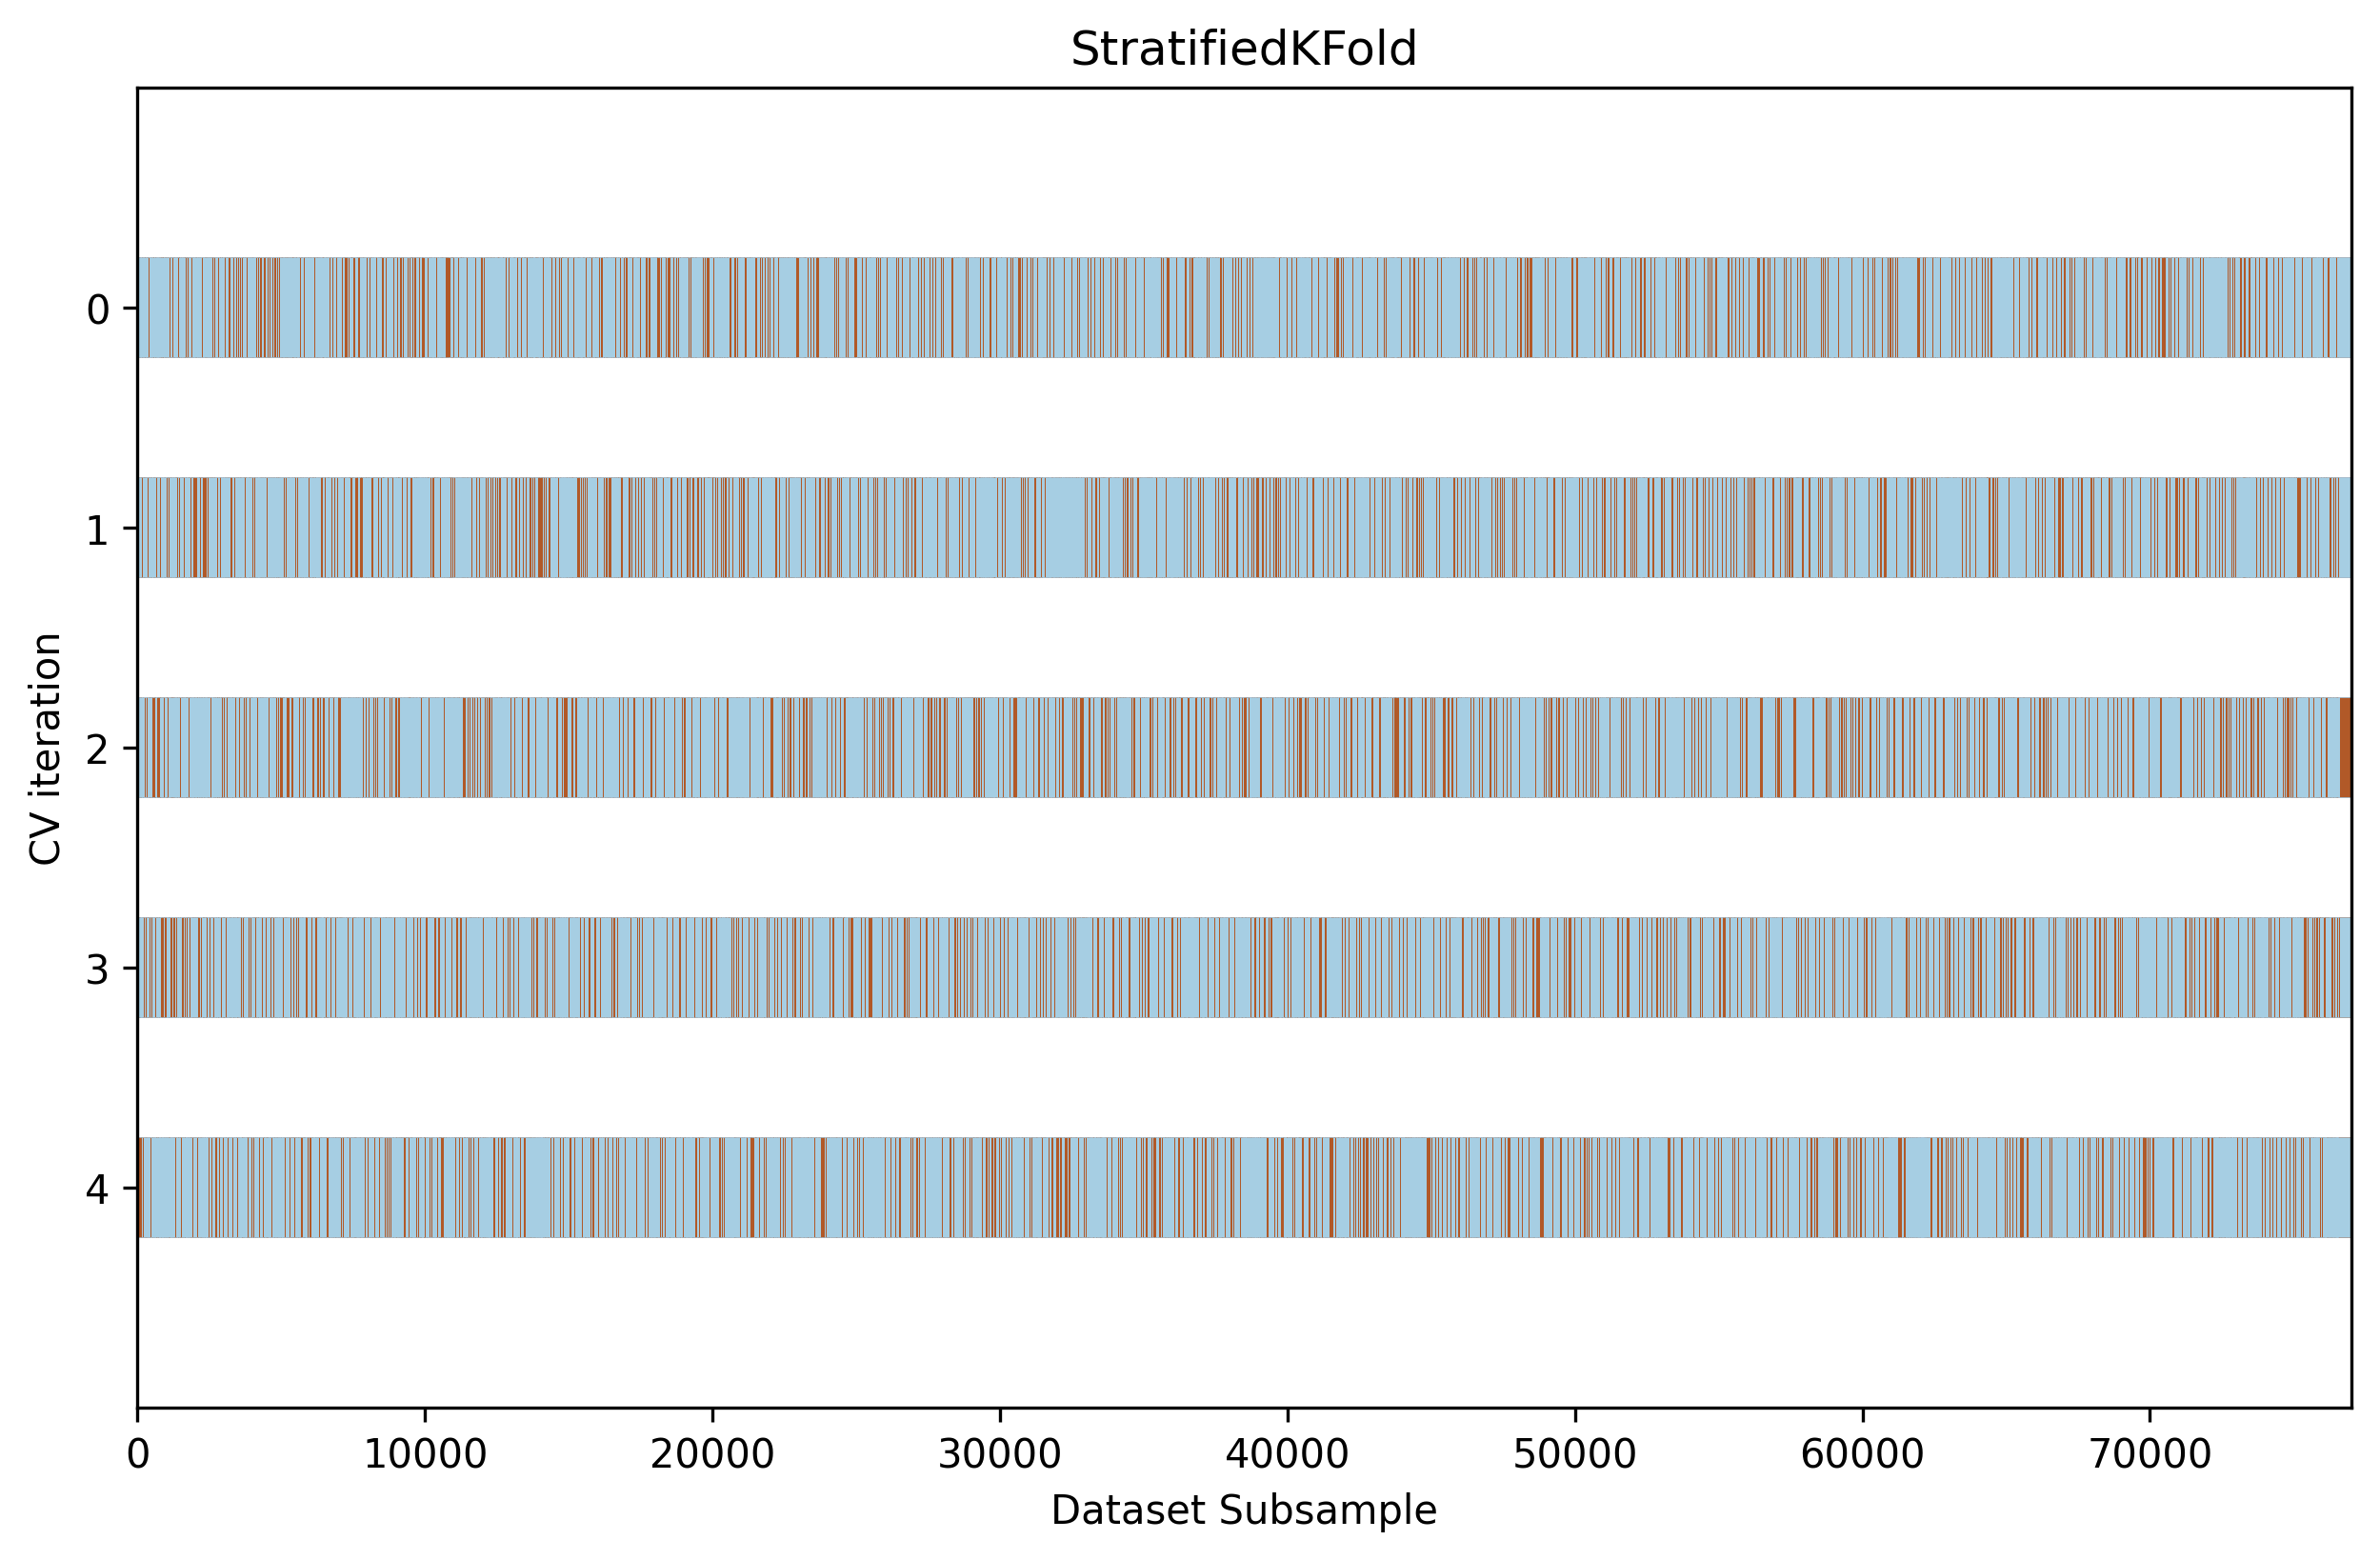

LGBM IB/IB_Encoded Dataset


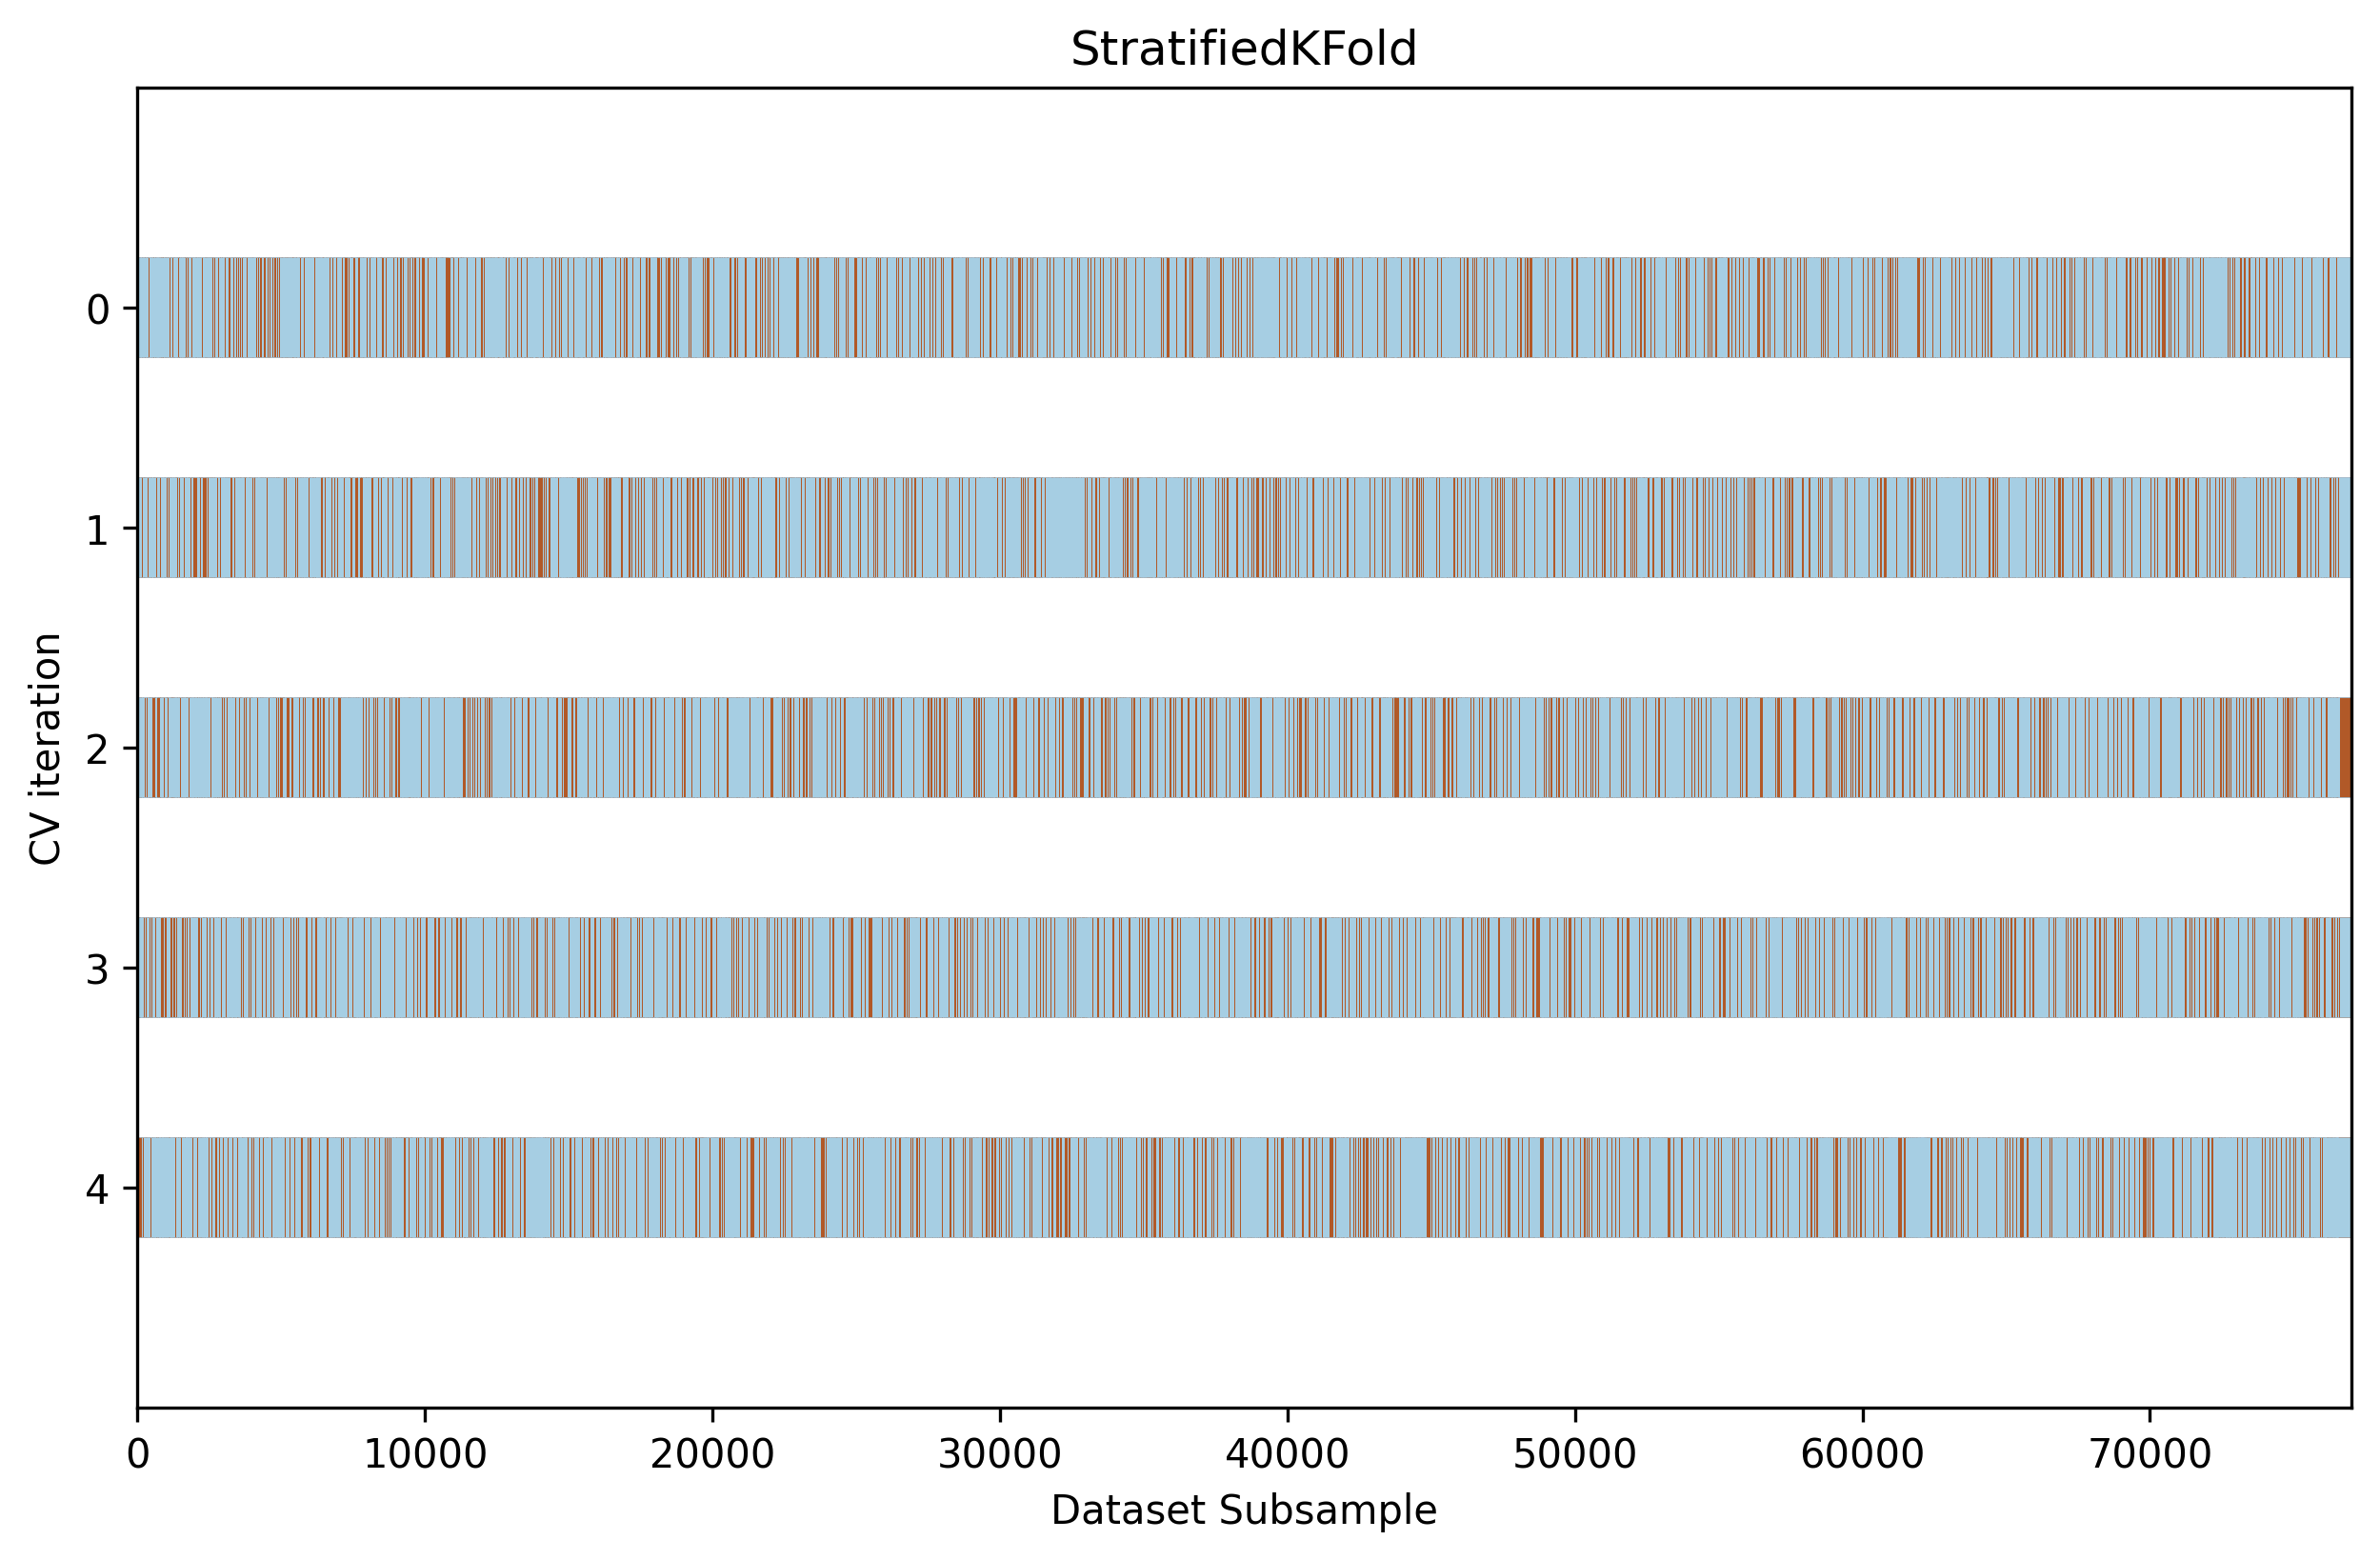

In [6]:
print("Stratified K-Folds Split at",K,"splits.")
print("LGBM TB/TB_Encoded Dataset")
kfolds_vis(tb_train)
print("LGBM IB/IB_Encoded Dataset")
kfolds_vis(ib_train)

In [7]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train_CATB, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train_CATB, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

display(tb_train.head())
display(ib_train.head())

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LdrGetProcedureAddress,LookupAccountSidW,LdrGetProcedureAddress,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress
1,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
3,0,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile
4,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Stratified K-Folds Split at 5 splits.
CATB TB/TB_Encoded Dataset


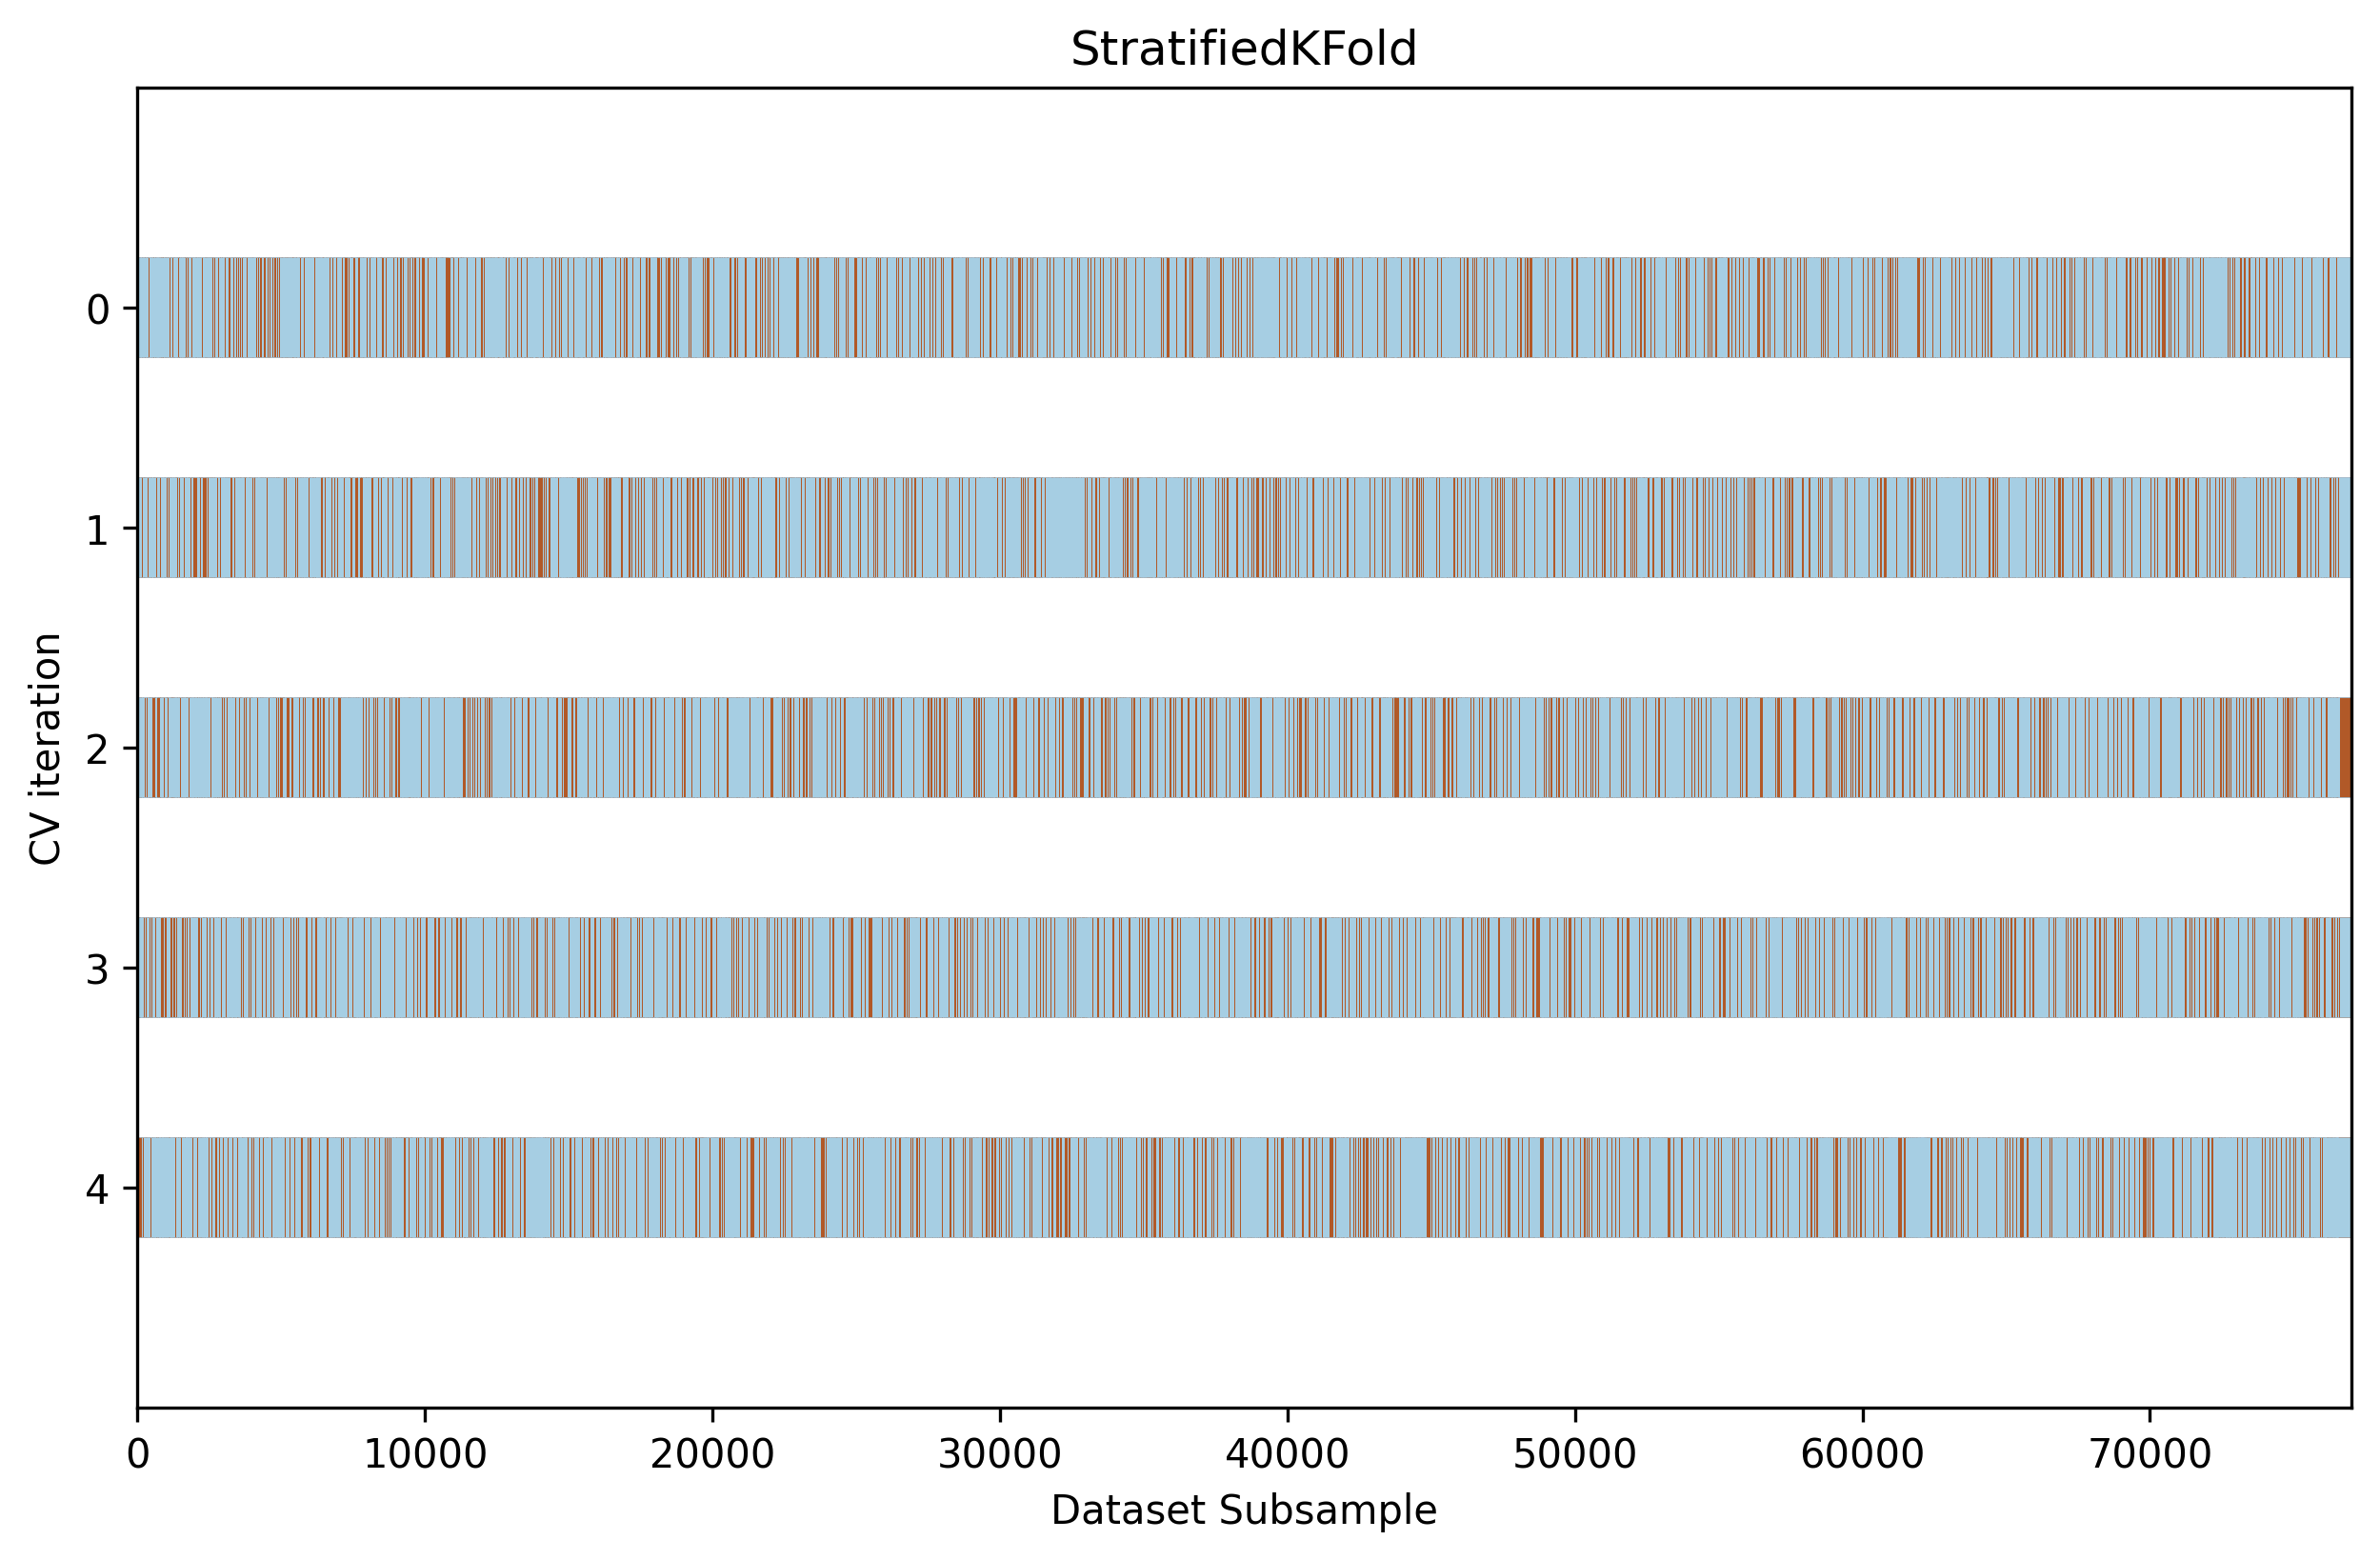

CATB IB/IB_Encoded Dataset


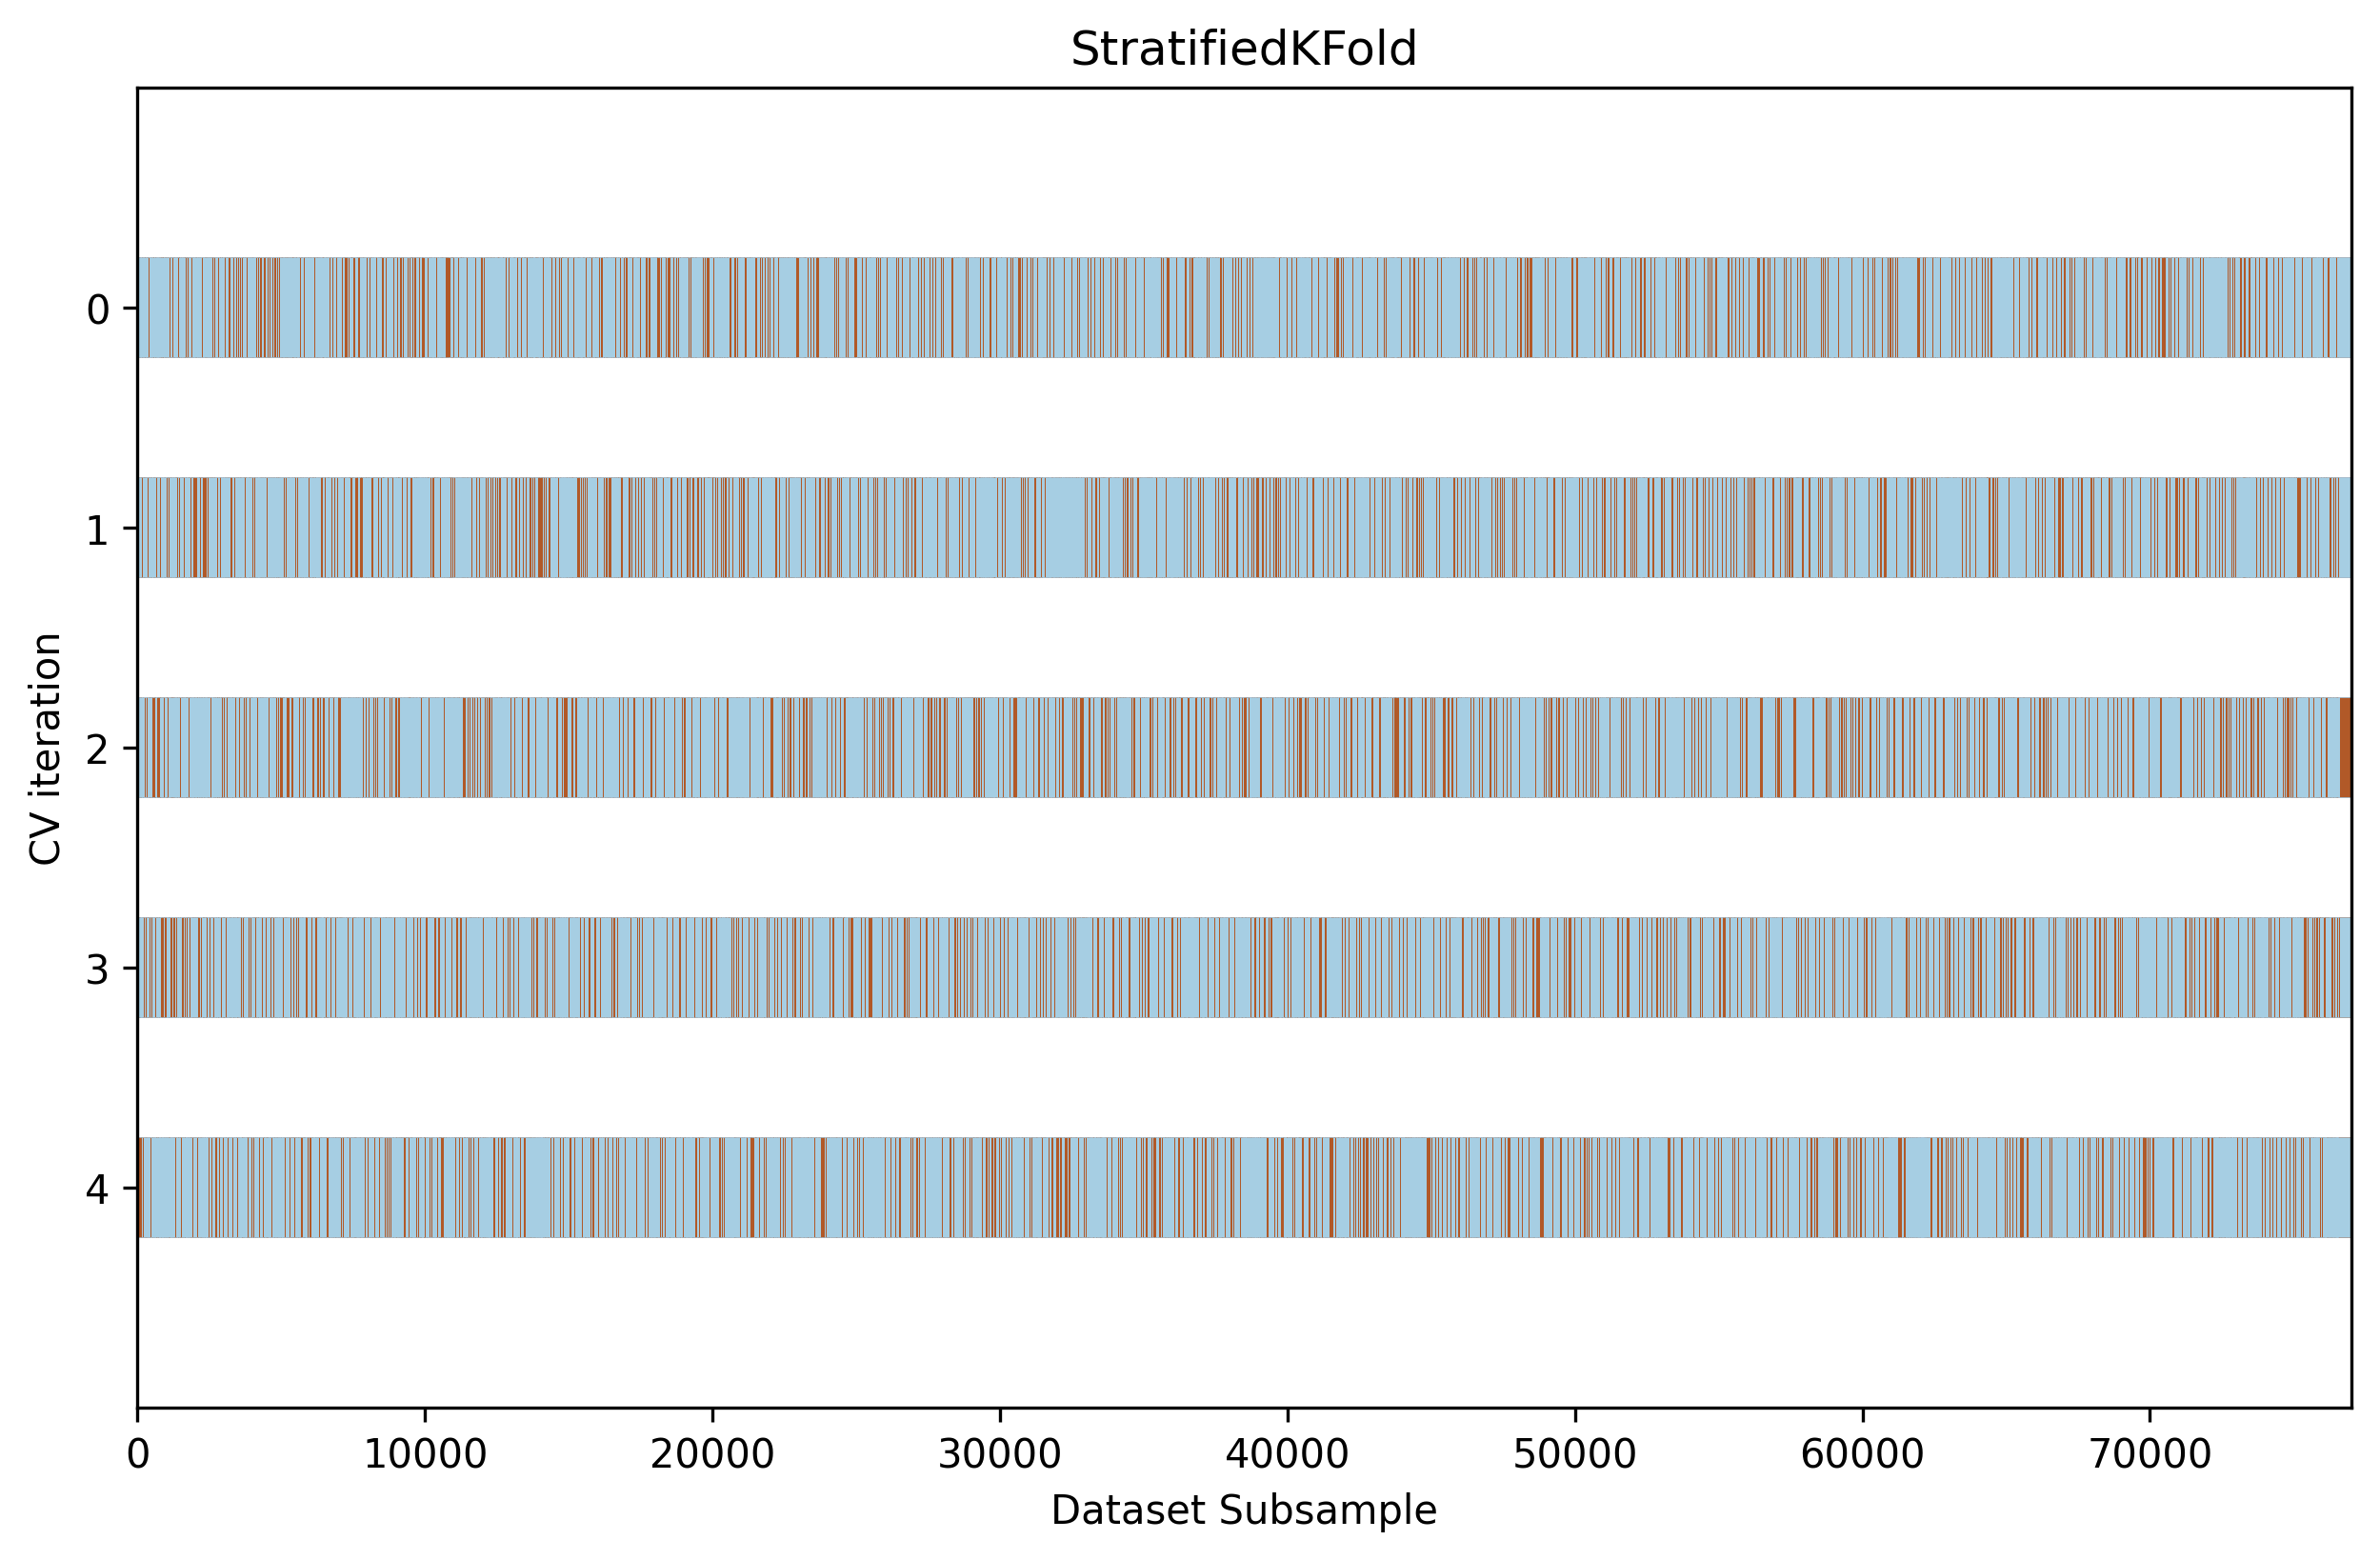

In [8]:
print("Stratified K-Folds Split at",K,"splits.")
print("CATB TB/TB_Encoded Dataset")
kfolds_vis(tb_train)
print("CATB IB/IB_Encoded Dataset")
kfolds_vis(ib_train)